In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy
import scanpy as sc
import scvi
import os
import sklearn.cluster as cluster
import scdrs

sc.set_figure_params(figsize=(4, 4))

In [14]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated_sketch.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 50000 × 5000
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id_x', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'Z_0', 'Z_1', 

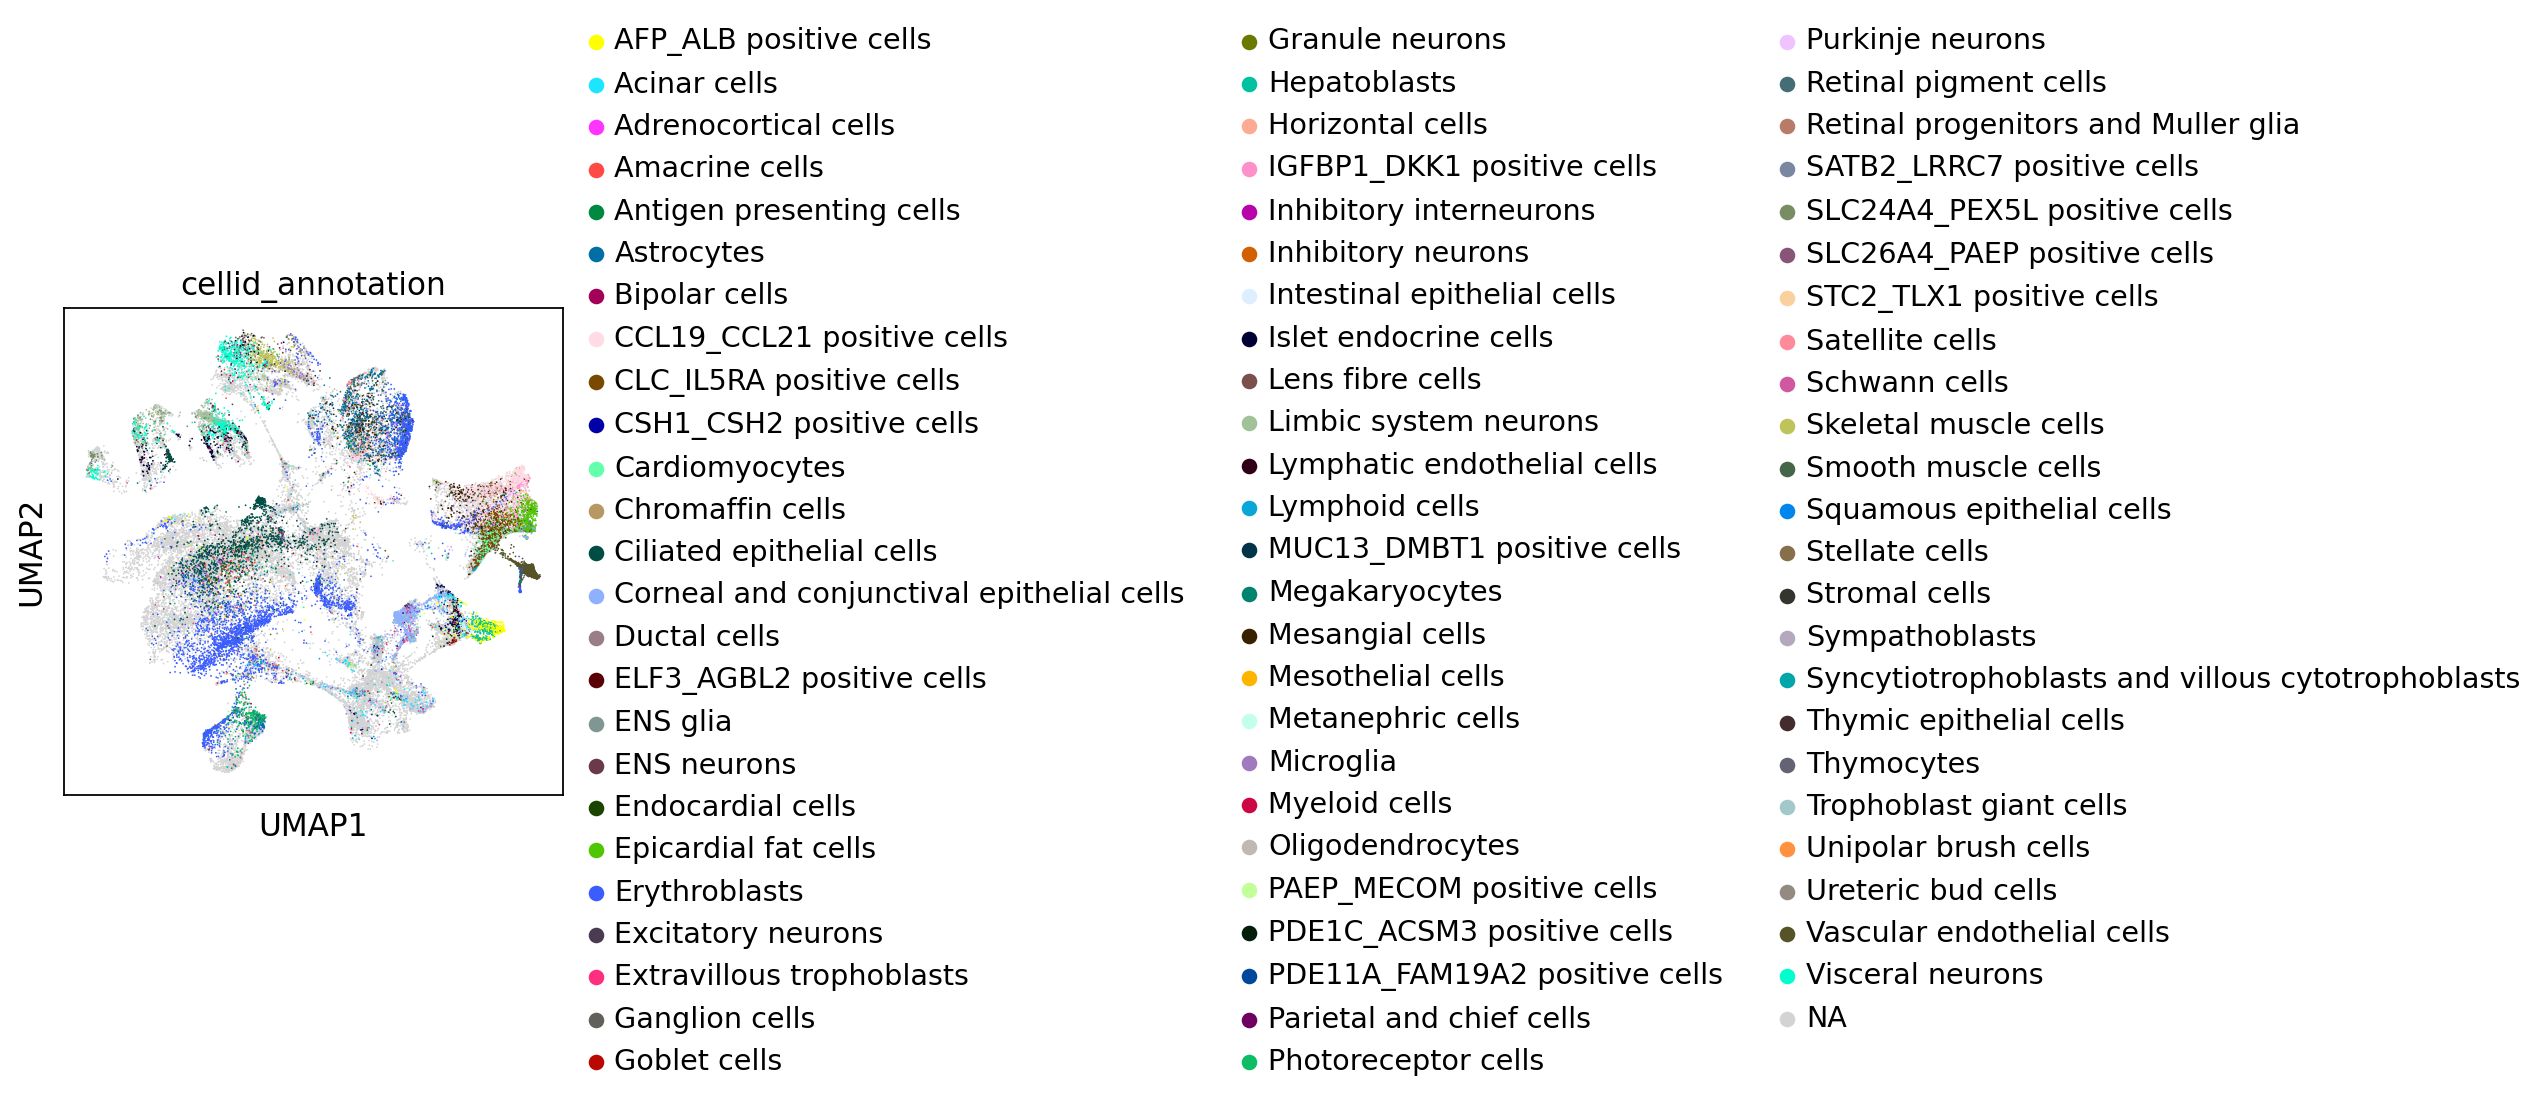

In [34]:
sc.pl.umap(adata, color='cellid_annotation')

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


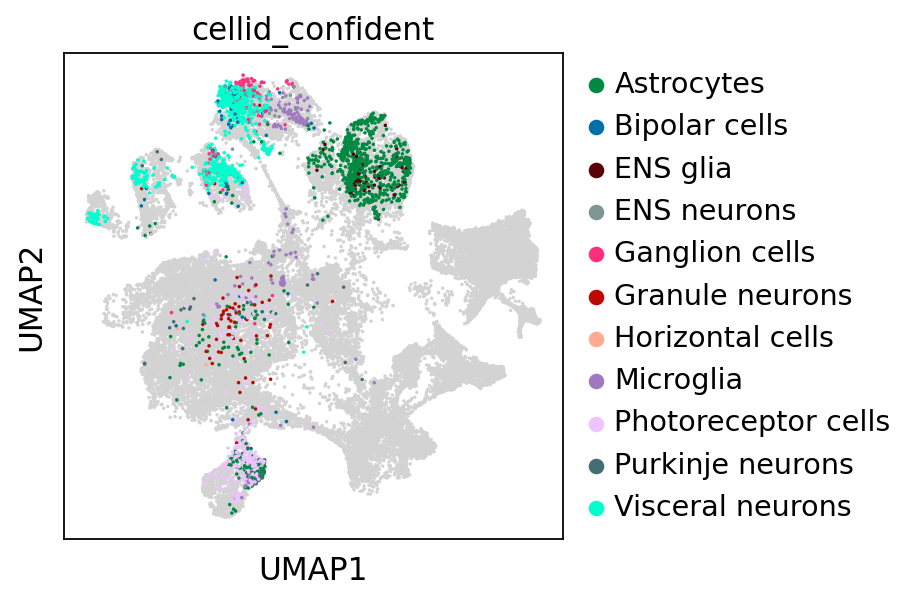

In [25]:
sc.pl.umap(adata, color="cellid_confident", groups=['Visceral neurons', 'ENS neurons', 'ENS glia',
                                                    'Granule neurons', 'Purkinje neurons', 'Astrocytes', 'Microglia',
                                                    'Limbic neurons', 
                                                    'Ganglion cells', 'Photoreceptor cells', 'Horizontal cells', 'Bipolar cells'], 
          size=10, na_in_legend=False)

In [4]:
scran_norm = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [5]:
scran_sub = scran_norm[adata.obs_names]

## scDRS Basic Preprocessing

In [6]:
scdrs.preprocess(scran_sub)

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [7]:
df_gs = scdrs.util.load_gs("/project2/gilad/jpopp/ebQTL/data/scDRS/gs_files/zhang.magma_10kb_1000.74_traits.gs")

## scDRS Analysis for Schizophrenia (SCZ)

In [8]:
scz_gene_list = df_gs['PASS_Schizophrenia_Pardinas2018'][0]
scz_gene_weight = df_gs['PASS_Schizophrenia_Pardinas2018'][1]

In [9]:
scz_res = scdrs.score_cell(scran_sub, scz_gene_list, gene_weight=scz_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


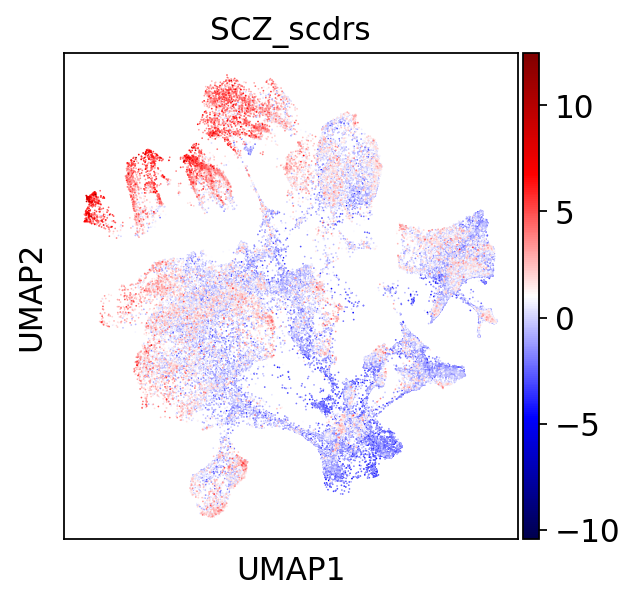

In [10]:
adata.obs['SCZ_scdrs'] = scz_res['norm_score']
sc.pl.umap(adata, color='SCZ_scdrs', cmap="seismic")

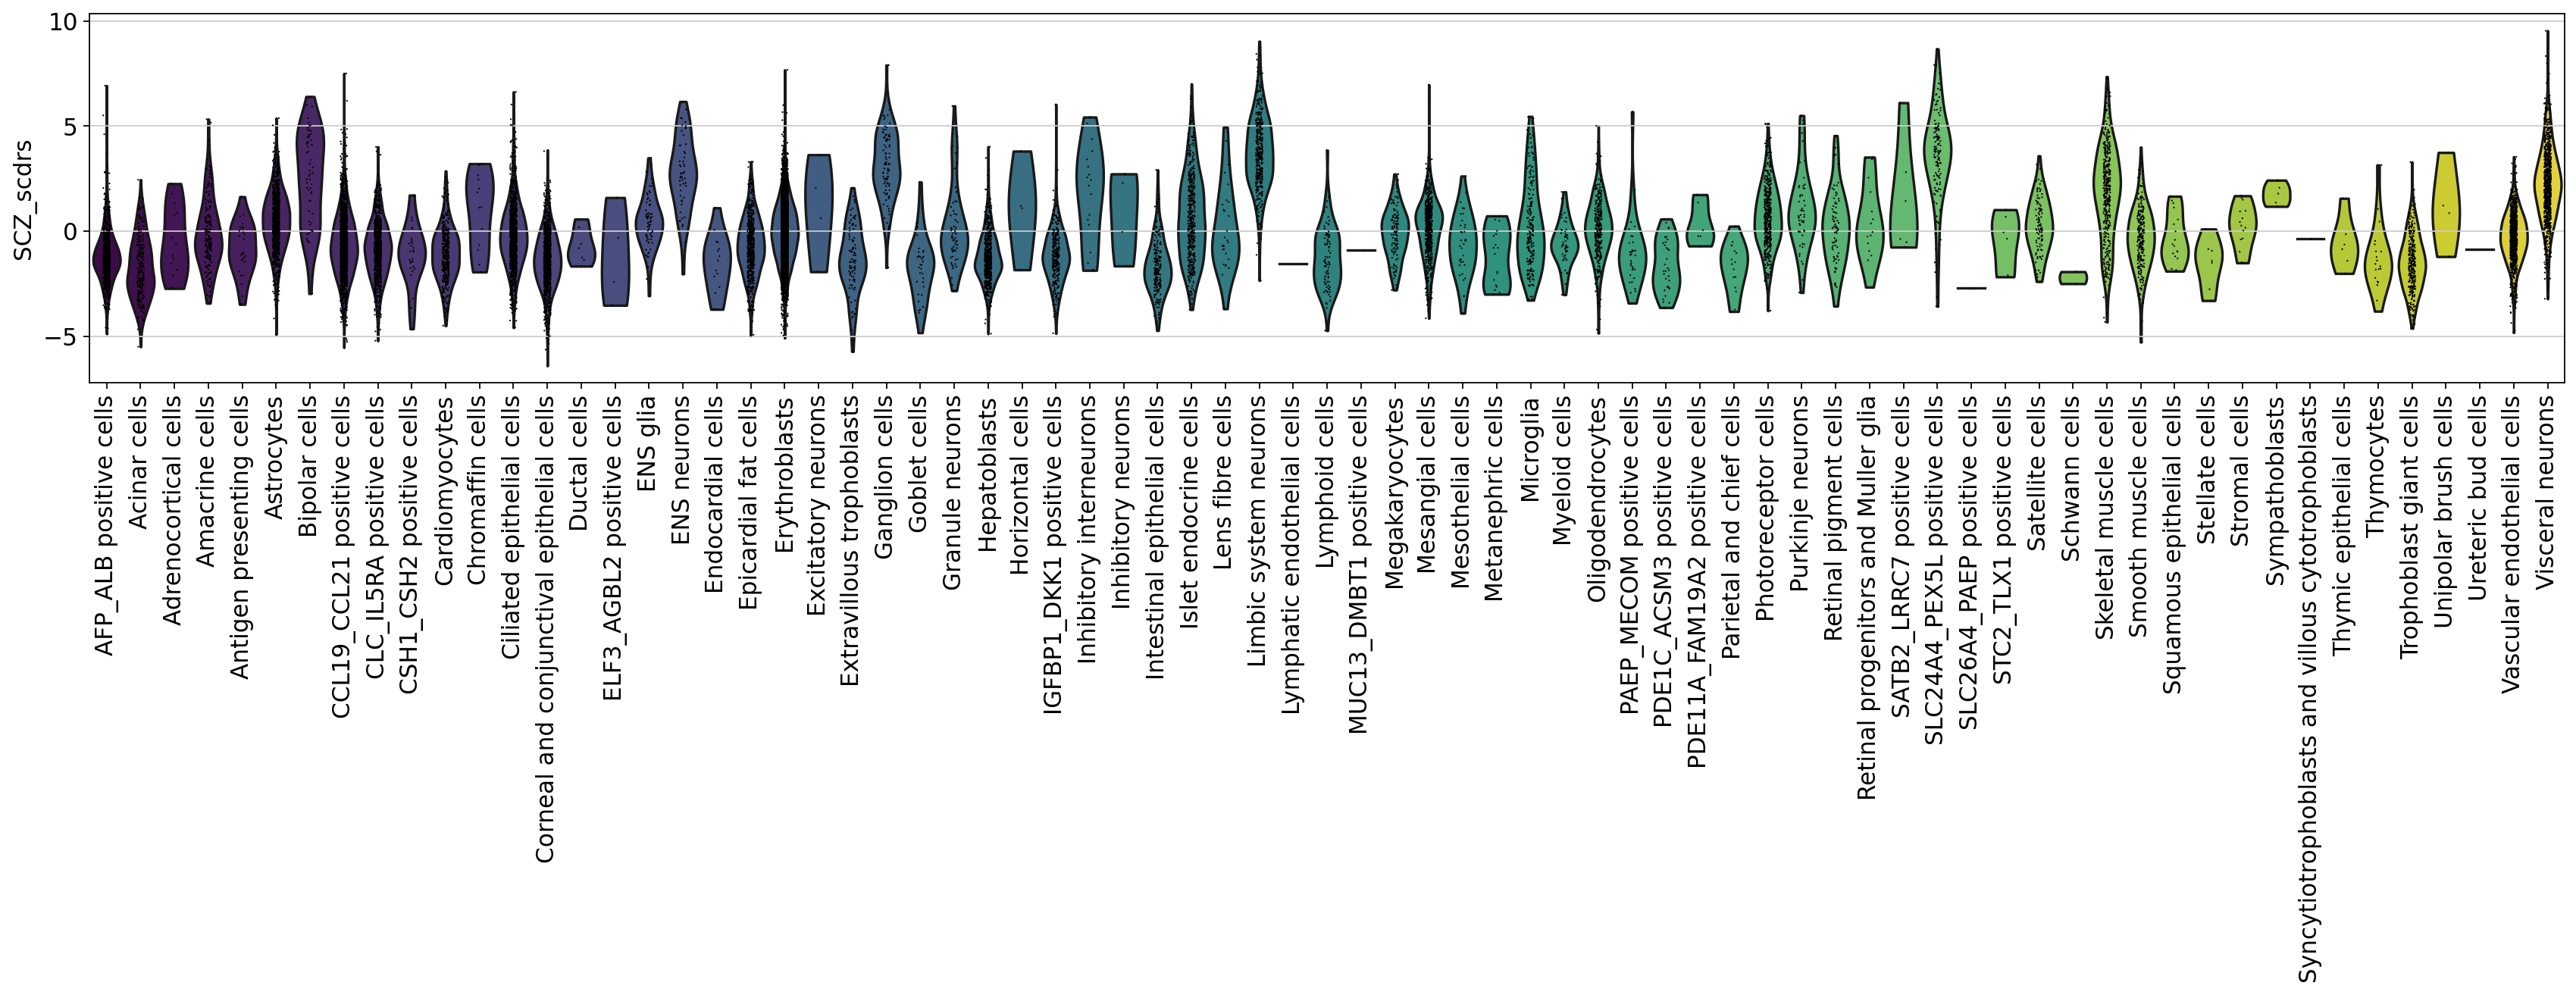

In [55]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'SCZ_scdrs', groupby='cellid_annotation', rotation=90)

## scDRS Analysis for Alzheimer's Disease

In [15]:
ad_gene_list = df_gs['PASS_Alzheimers_Jansen2019'][0]
ad_gene_weight = df_gs['PASS_Alzheimers_Jansen2019'][1]

In [16]:
ad_res = scdrs.score_cell(scran_sub, ad_gene_list, gene_weight=ad_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [17]:
ad_res

raw_score  norm_score   mc_pval      pval  nlog10_pval  \
cell                                                                           
GATGATCTCATGAGAA-22    0.134870   -0.381582  0.619048  0.637436     0.195563   
GCGATCGAGGTCGCCT-67    0.158049   -2.346694  1.000000  0.994577     0.002362   
CTAACCCTCGAACGGA-67    0.198377    0.080220  0.523810  0.461801     0.335546   
TTATTGCCACTACGGC-17    0.245507    1.875359  0.095238  0.032751     1.484776   
TCAATCTGTACGACAG-20    0.218637   -0.055028  0.571429  0.513671     0.289315   
...                         ...         ...       ...       ...          ...   
TTGCCTGGTCGGCTAC-107   0.160092    0.754510  0.333333  0.229970     0.638329   
CTCATCGTCTAGCAAC-23    0.193992   -0.638073  0.761905  0.727602     0.138106   
GATTTCTGTATGGTAA-101   0.214632   -1.266589  0.857143  0.895888     0.047746   
TCATTTGGTTTCGTTT-58    0.207898    0.666560  0.285714  0.256170     0.591472   
TAACACGAGTTGGACG-3     0.203867   -1.895866  0.952381  0.975663     0.010700   

                        zscore  
cell                            
GATGATCTCATGAGAA-22  -0.351615  
GCGATCGAGGTCGCCT-67  -2.547622  
CTAACCCTCGAACGGA-67   0.095899  
TTATTGCCACTACGGC-17   1.841817  
TCAATCTGTACGACAG-20  -0.034274  
...                        ...  
TTGCCTGGTCGGCTAC-107  0.738946  
CTCATCGTCTAGCAAC-23  -0.605577  
GATTTCTGTATGGTAA-101 -1.258465  
TCATTTGGTTTCGTTT-58   0.655199  
TAACACGAGTTGGACG-3   -1.971437  

[50000 rows x 6 columns]

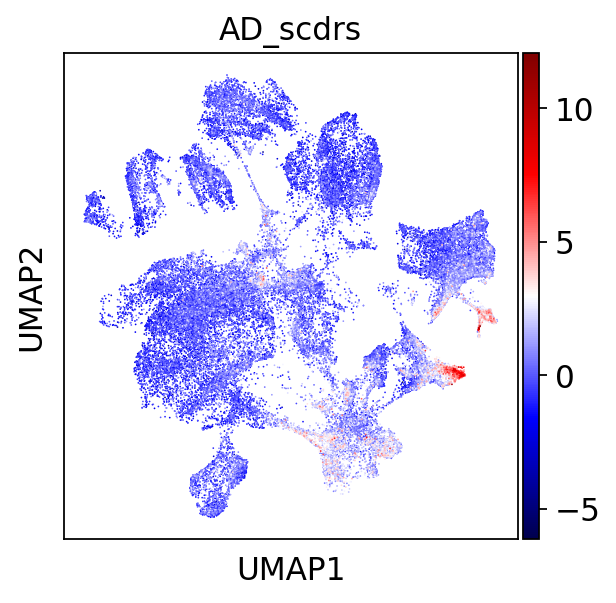

In [20]:
adata.obs['AD_scdrs'] = ad_res['norm_score']
sc.pl.umap(adata, color='AD_scdrs', cmap="seismic")

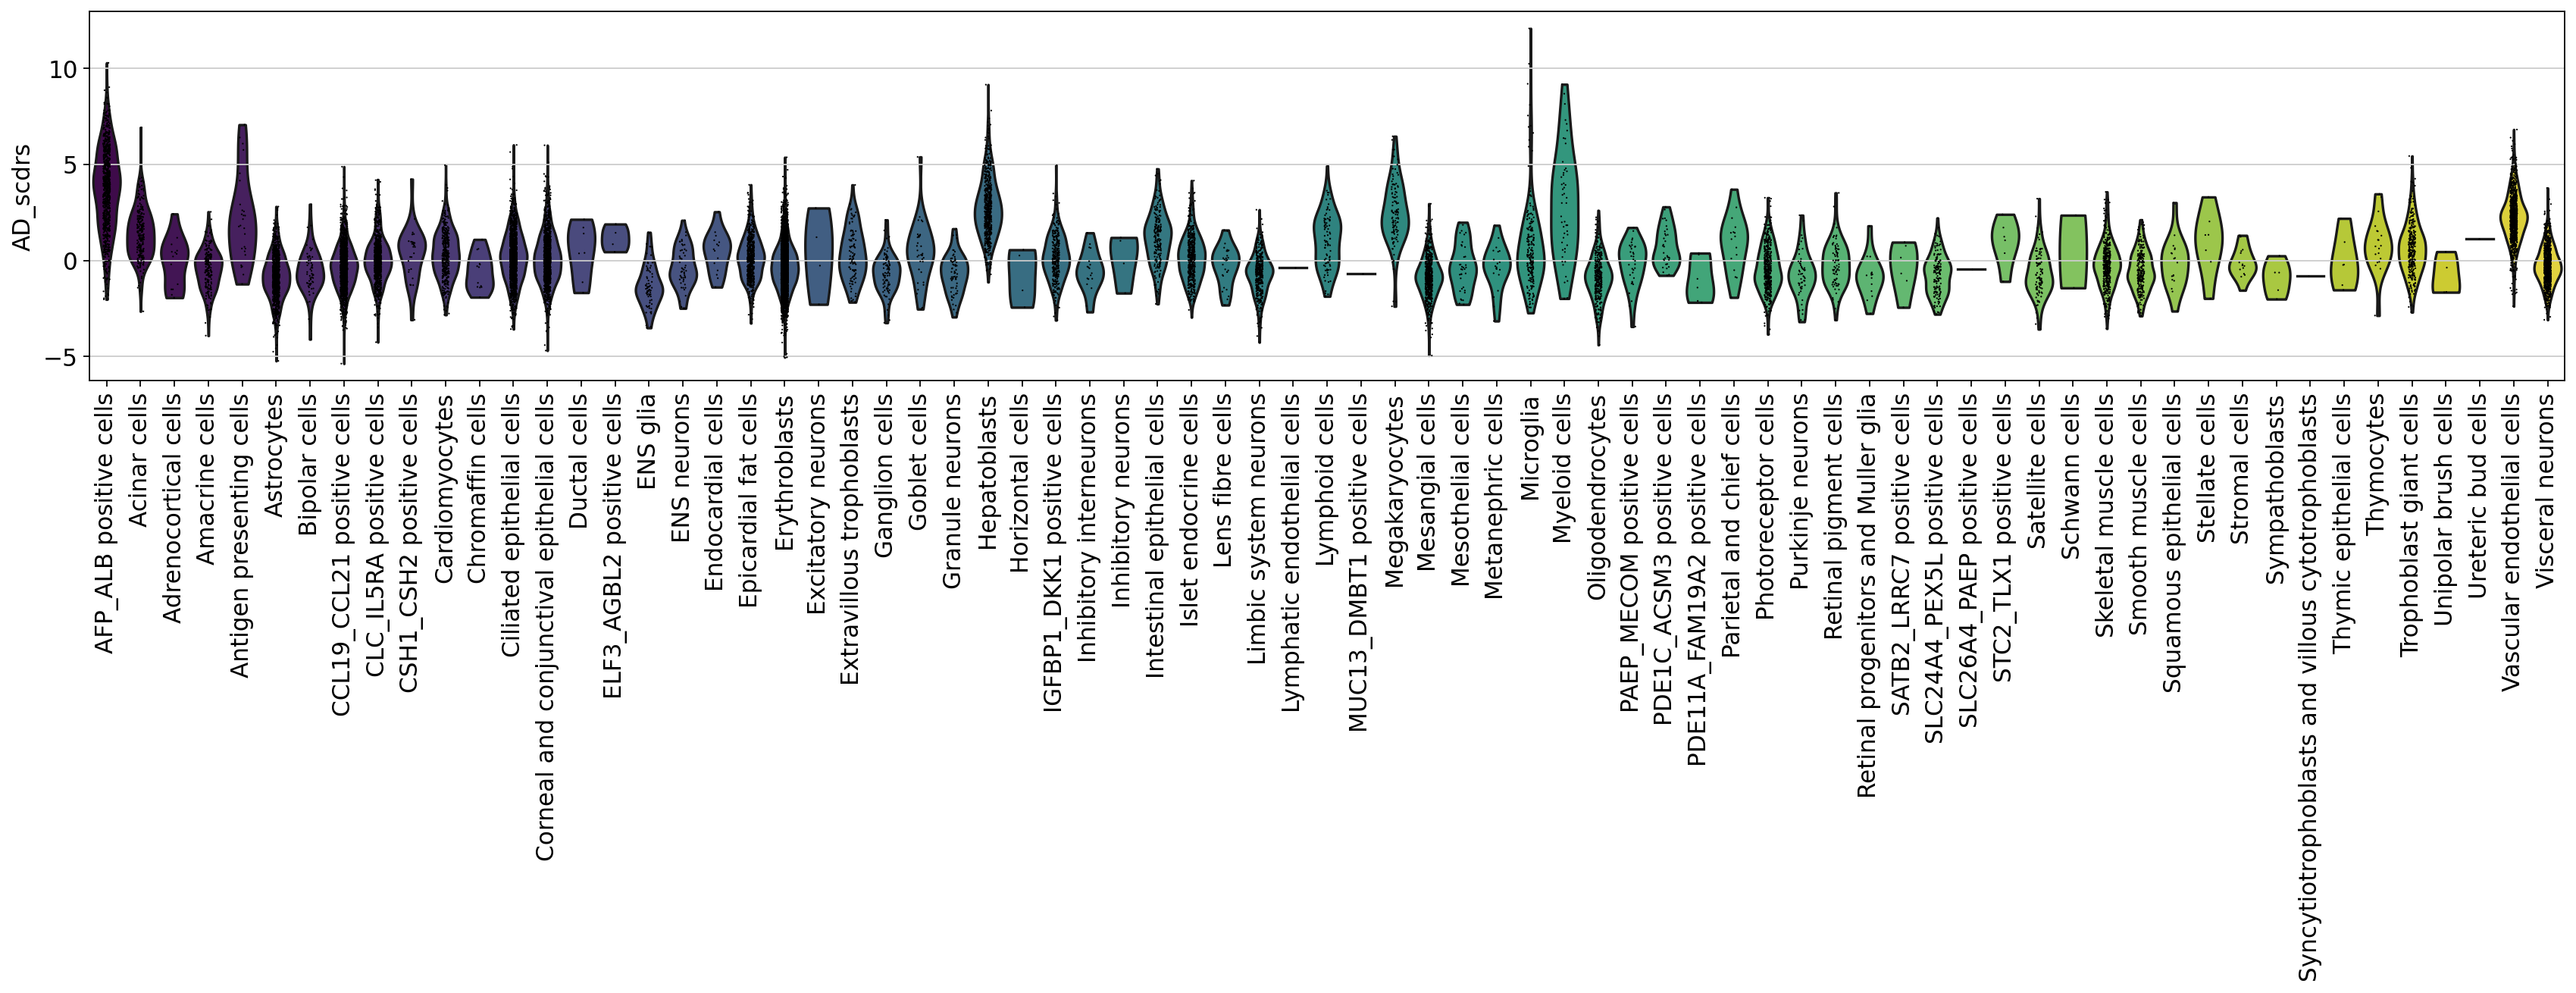

In [60]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'AD_scdrs', groupby='cellid_annotation', rotation=90)

## scDRS Analysis for Sleep Duration

In [21]:
sd_gene_list = df_gs['PASS_SleepDuration_Dashti2019'][0]
sd_gene_weight = df_gs['PASS_SleepDuration_Dashti2019'][1]

In [22]:
sd_res = scdrs.score_cell(scran_sub, sd_gene_list, gene_weight=sd_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


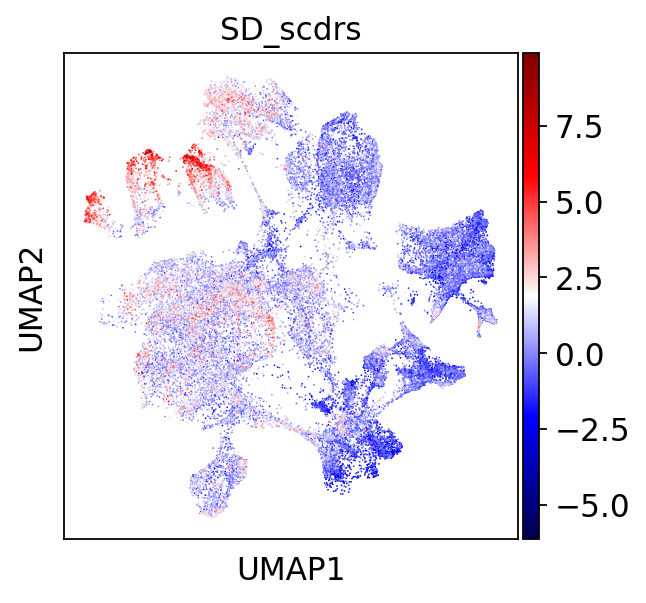

In [24]:
adata.obs['SD_scdrs'] = sd_res['norm_score']
sc.pl.umap(adata, color='SD_scdrs', cmap="seismic")

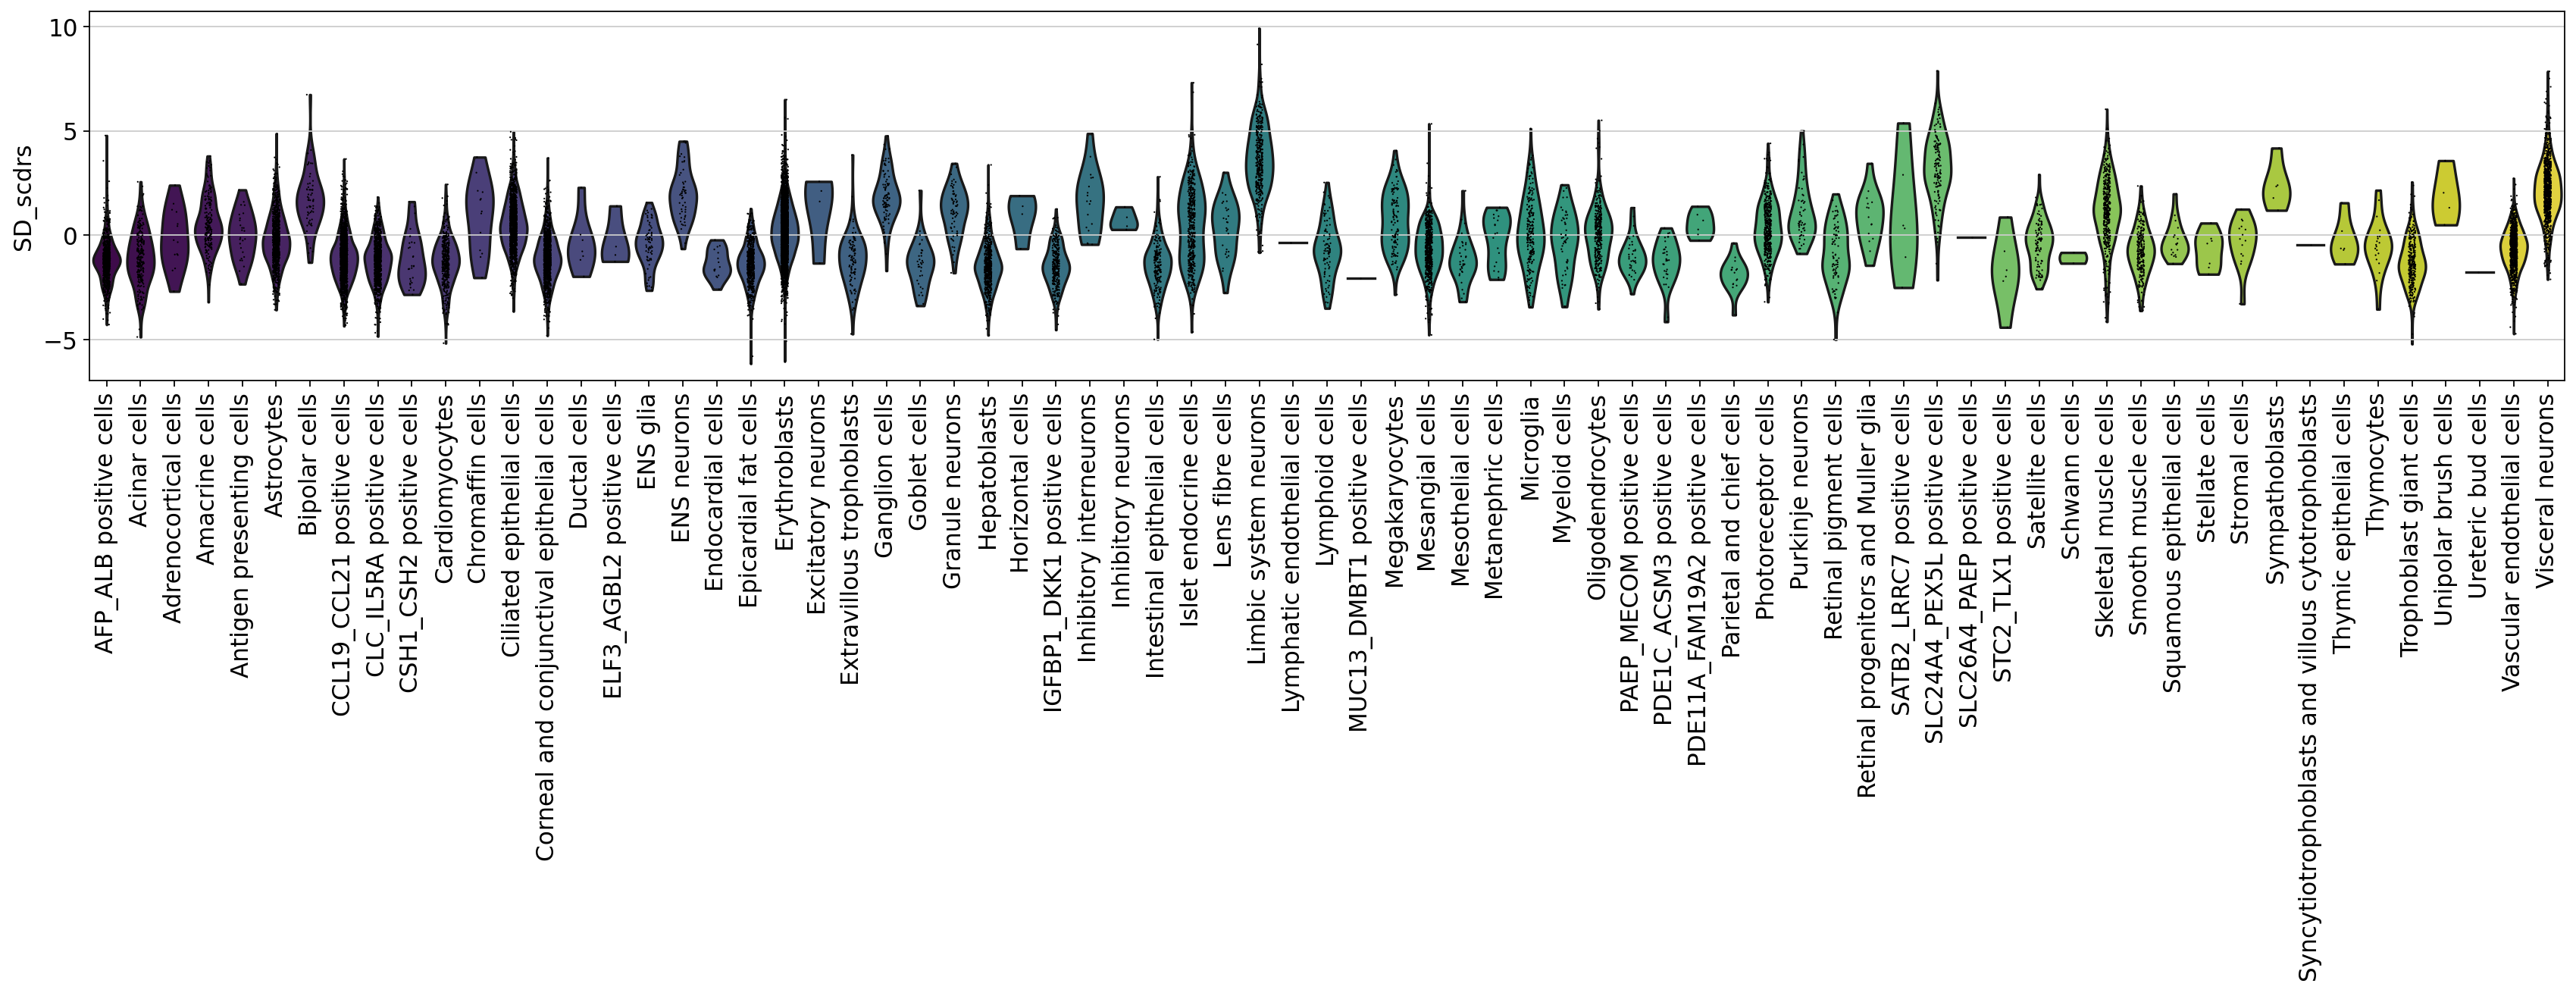

In [53]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'SD_scdrs', groupby='cellid_annotation', rotation=90)

## scDRS Analysis for Reaction Time

In [26]:
rt_gene_list = df_gs['PASS_ReactionTime_Davies2018'][0]
rt_gene_weight = df_gs['PASS_ReactionTime_Davies2018'][1]

In [27]:
rt_res = scdrs.score_cell(scran_sub, rt_gene_list, gene_weight=rt_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


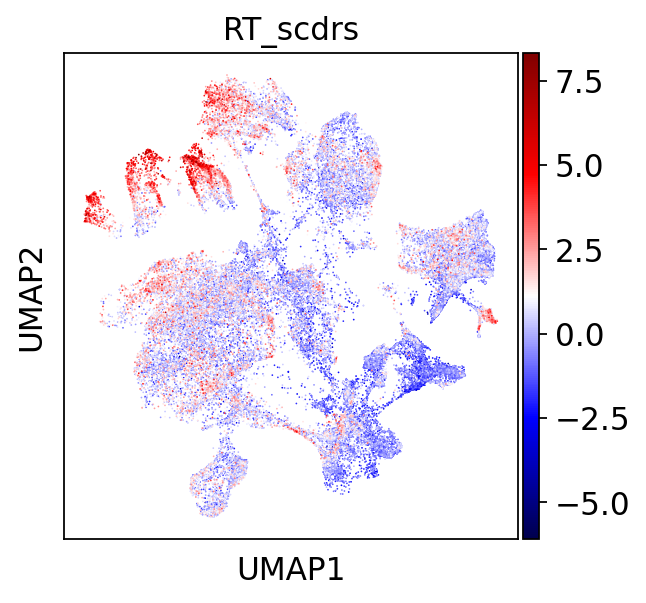

In [28]:
adata.obs['RT_scdrs'] = rt_res['norm_score']
sc.pl.umap(adata, color='RT_scdrs', cmap="seismic")

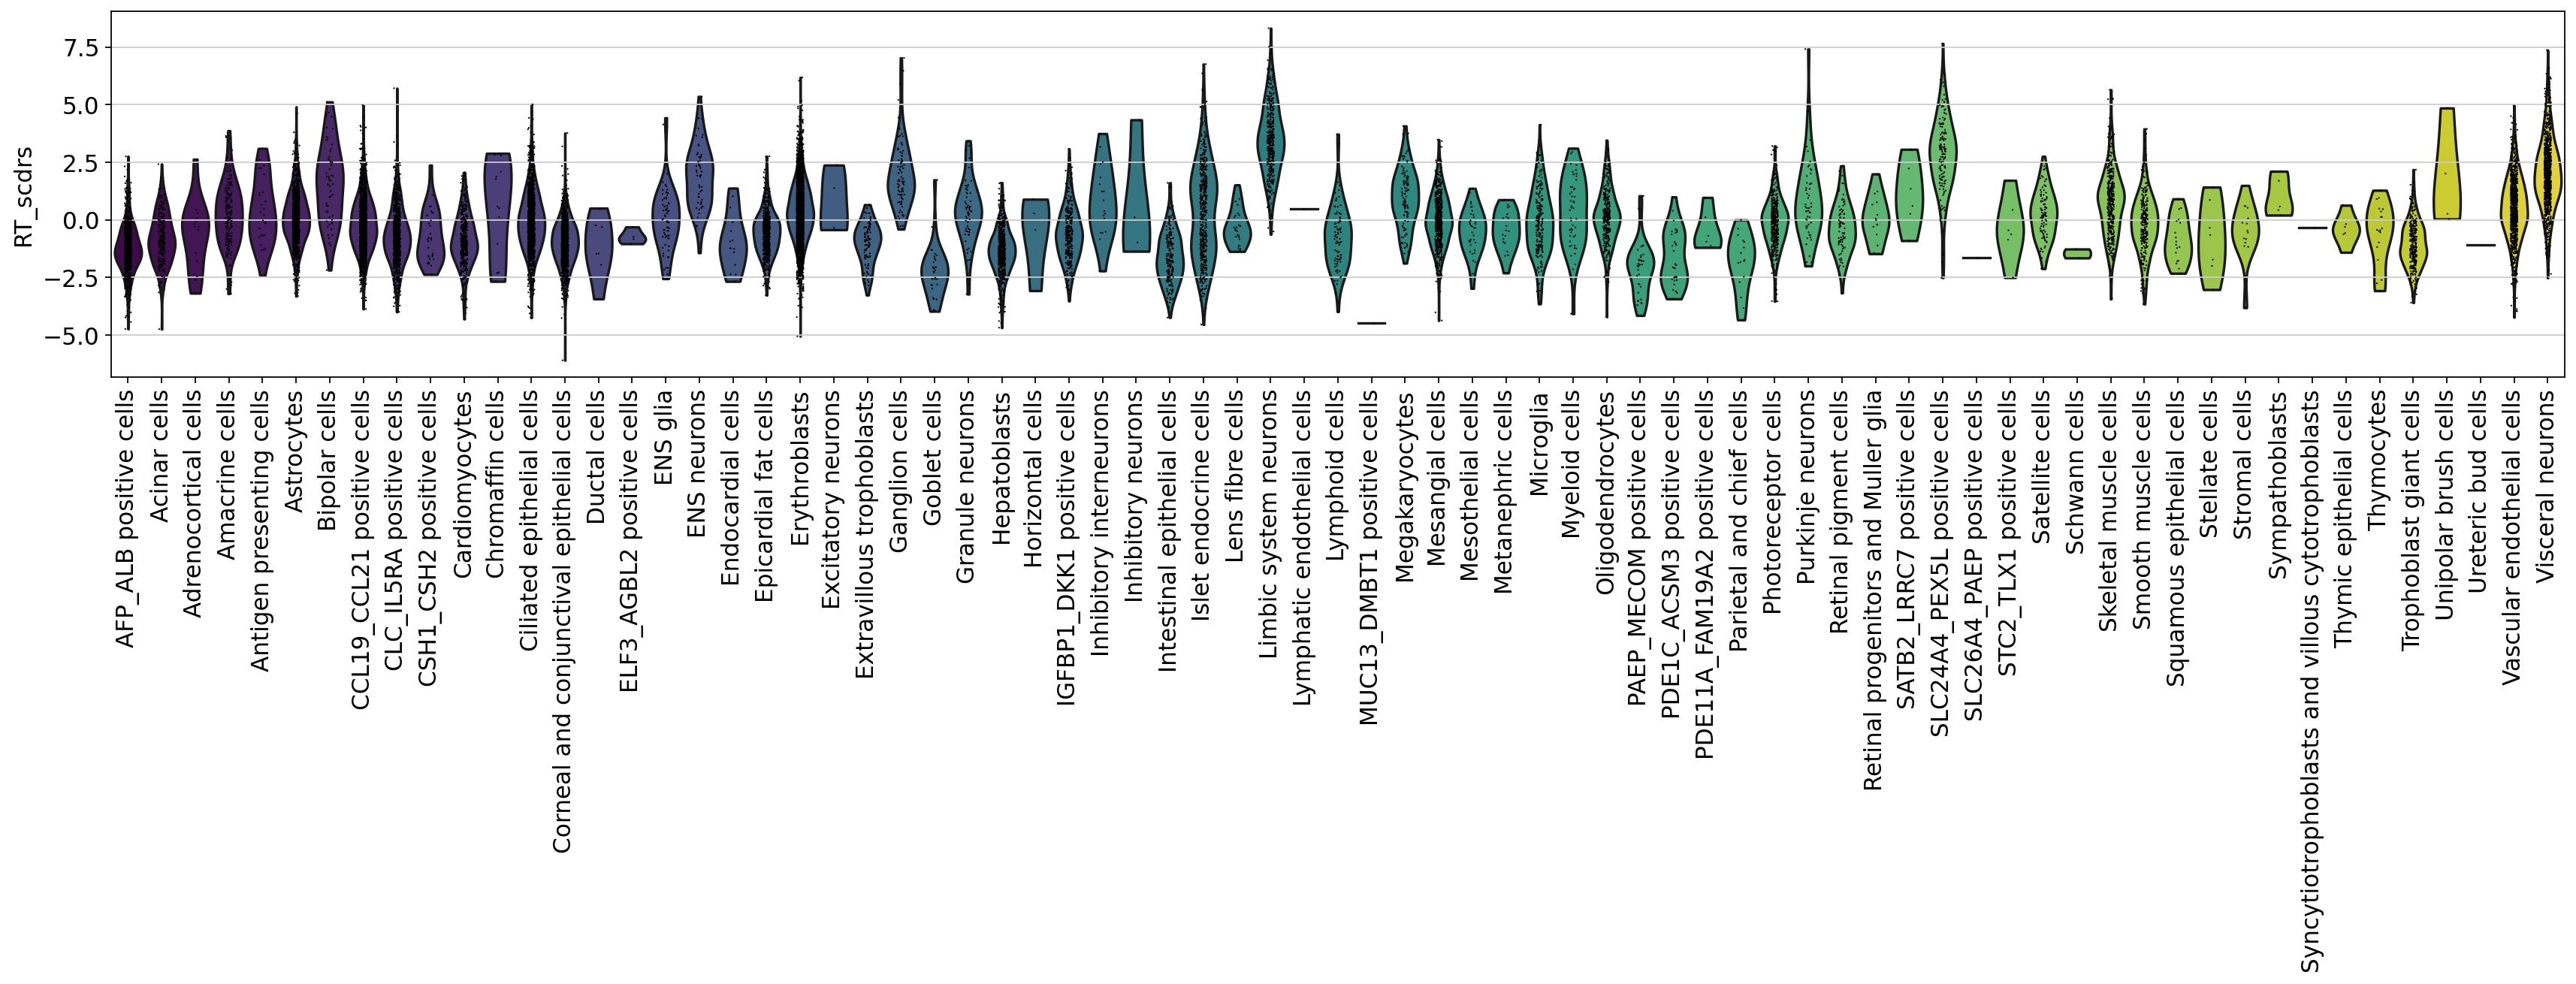

In [52]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'RT_scdrs', groupby='cellid_annotation', rotation=90)

## scDRS Analysis for Major Depressive Disorder

In [29]:
mdd_gene_list = df_gs['PASS_MDD_Howard2019'][0]
mdd_gene_weight = df_gs['PASS_MDD_Howard2019'][1]

In [30]:
mdd_res = scdrs.score_cell(scran_sub, mdd_gene_list, gene_weight=mdd_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


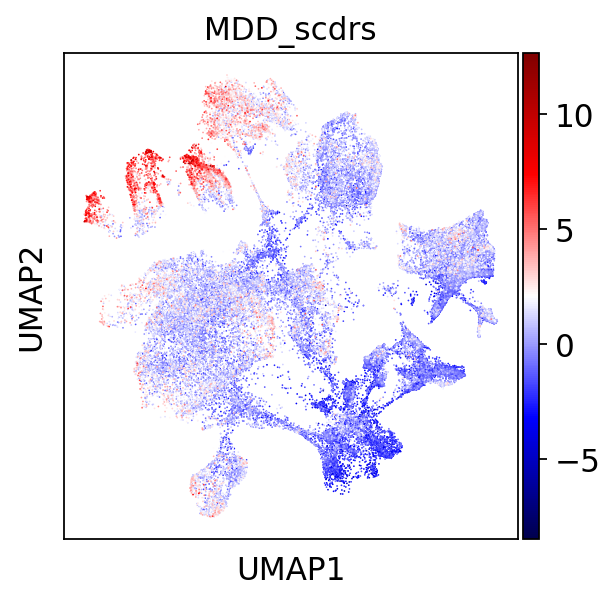

In [64]:
sc.set_figure_params(figsize=(4, 4))
adata.obs['MDD_scdrs'] = mdd_res['norm_score']
sc.pl.umap(adata, color='MDD_scdrs', cmap="seismic")

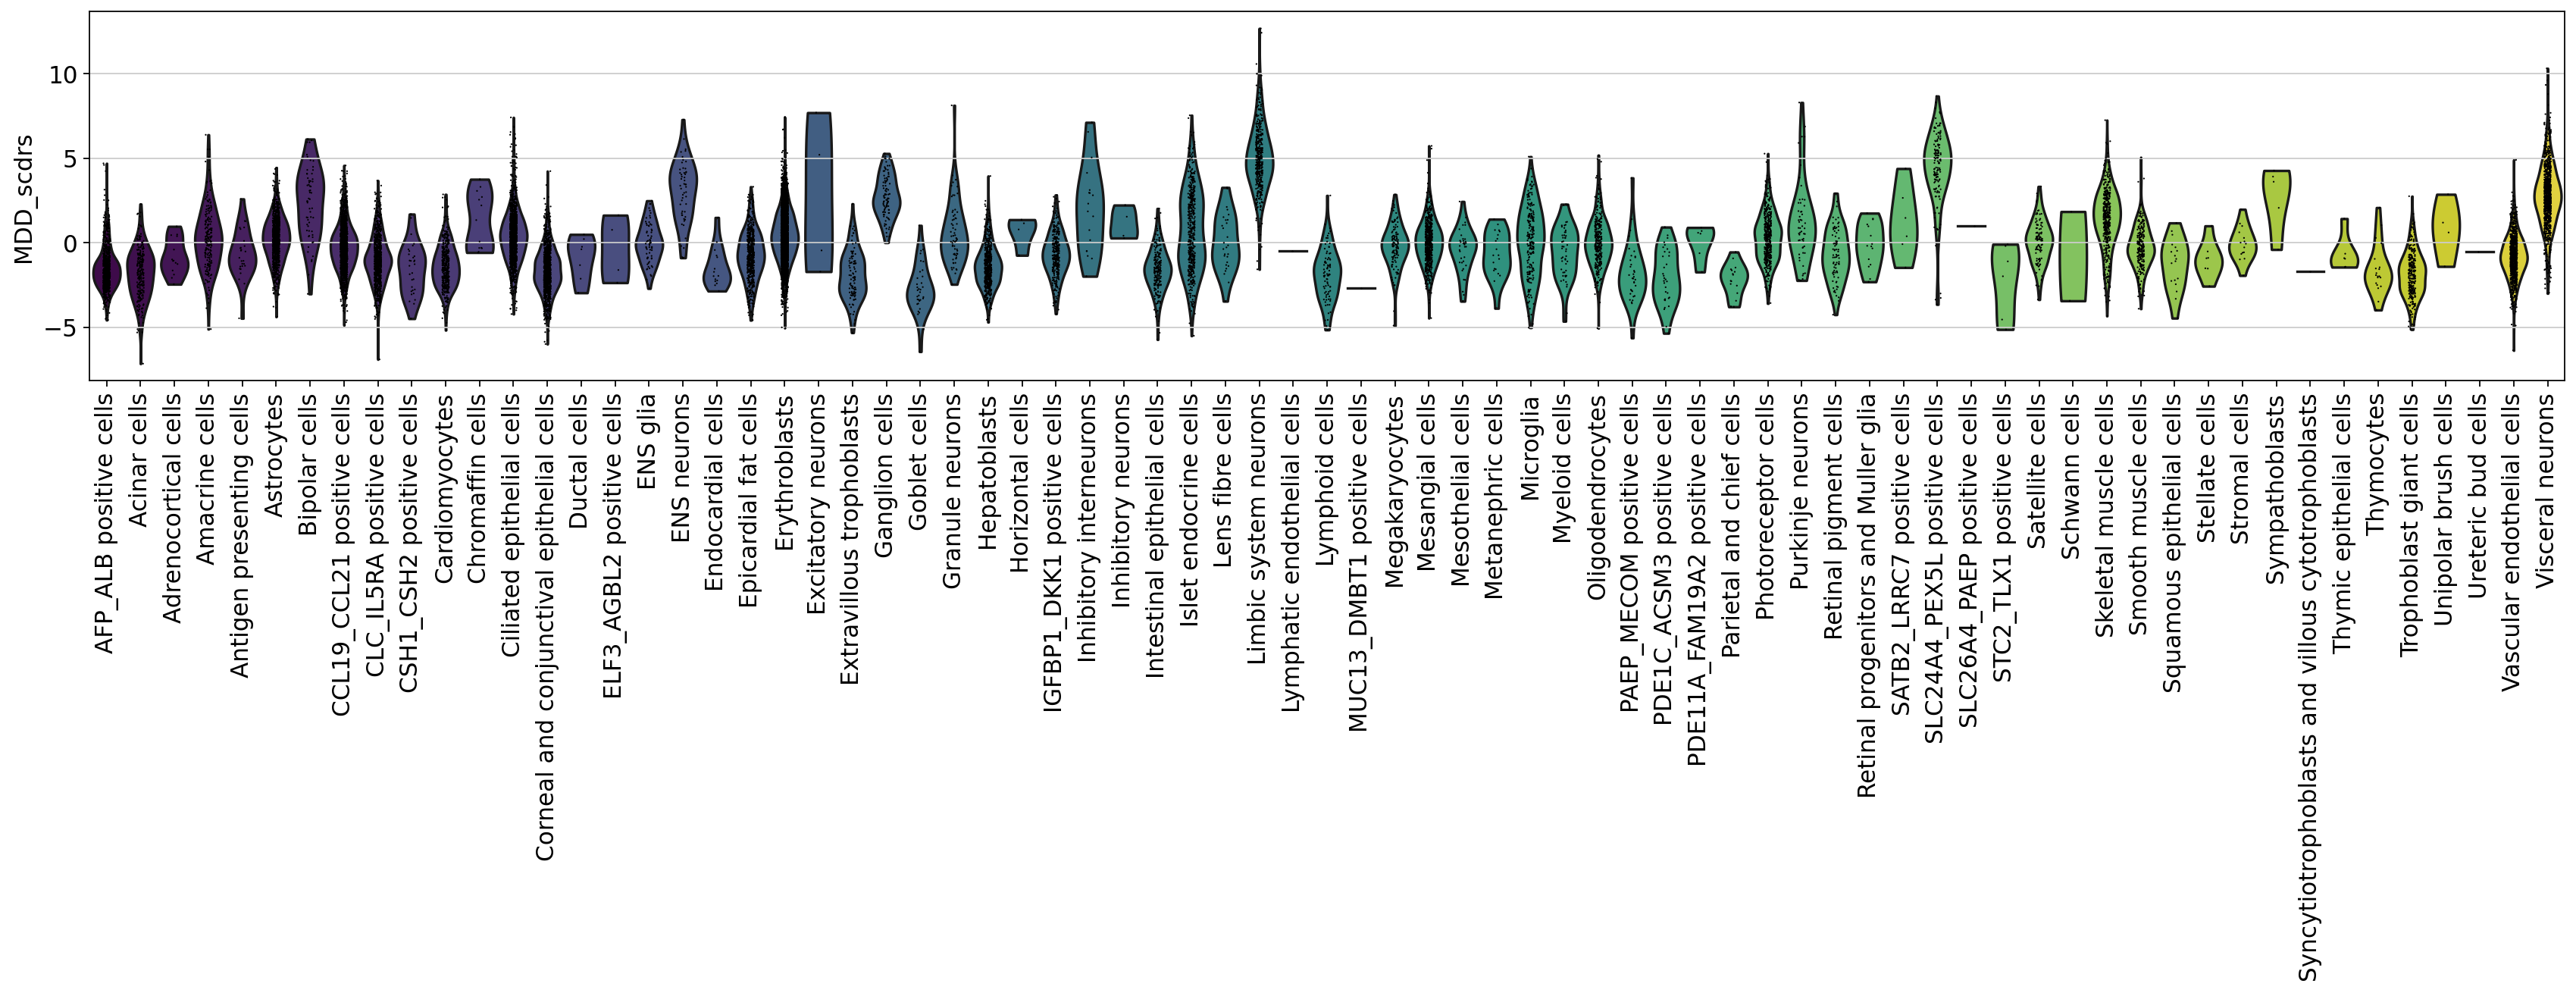

In [65]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'MDD_scdrs', groupby='cellid_annotation', rotation=90)

## scDRS Analysis for ADHD

In [66]:
adhd_gene_list = df_gs['PASS_ADHD_Demontis2018'][0]
adhd_gene_weight = df_gs['PASS_ADHD_Demontis2018'][1]

In [67]:
adhd_res = scdrs.score_cell(scran_sub, adhd_gene_list, gene_weight=adhd_gene_weight, n_ctrl=20)

Computing control scores: 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


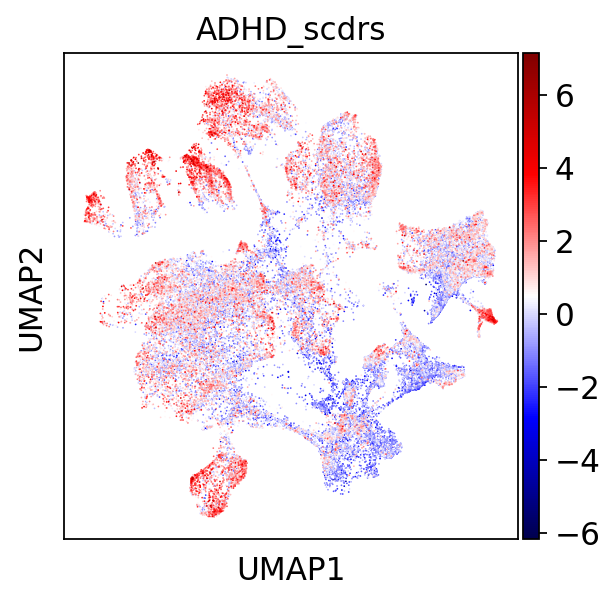

In [70]:
sc.set_figure_params(figsize=(4, 4))
adata.obs['ADHD_scdrs'] = adhd_res['norm_score']
sc.pl.umap(adata, color='ADHD_scdrs', cmap="seismic")

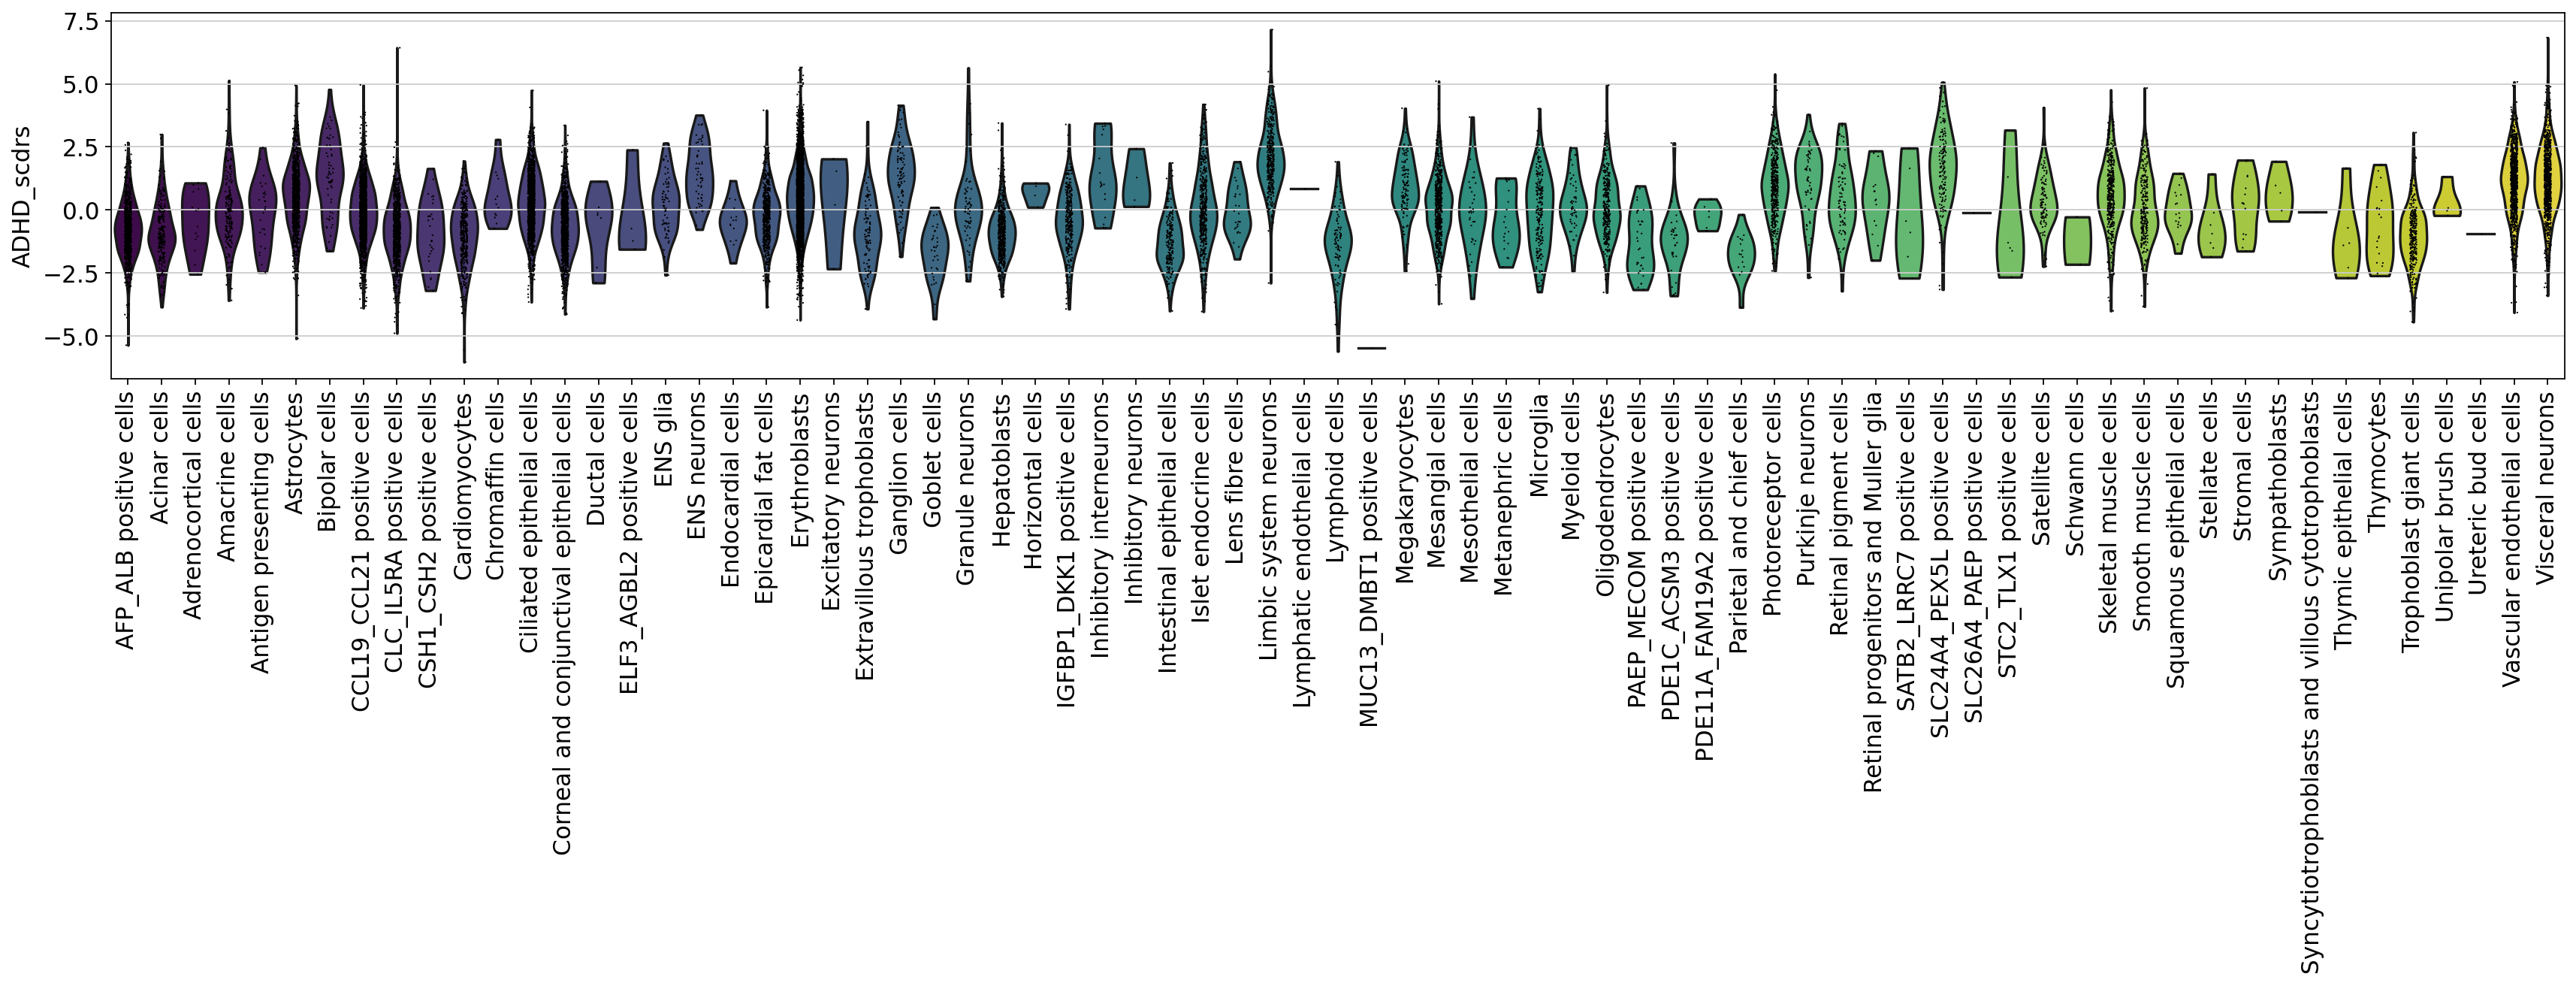

In [71]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.violin(adata, 'ADHD_scdrs', groupby='cellid_annotation', rotation=90)

In [72]:
adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated_sketch_neuro_scdrs.h5ad")